### Datasets
http://www.manythings.org/anki/  (Download and unzip mar-eng.zip file)

In [7]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [8]:
lines= pd.read_table('C:/Users/djroc/OneDrive/Desktop/mar.txt')

In [9]:
lines=pd.DataFrame(lines)

In [10]:
lines.shape

(43070, 3)

In [11]:
lines.head(5)

,Go.,जा.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #3138228 (sabretou)
0,Run!,पळ!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
1,Run!,धाव!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,Run!,पळा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run!,धावा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Who?,कोण?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [12]:
lines=lines.rename(columns={"Go.":"eng","जा.":"hin"})

In [7]:
lines.drop(['CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #3138228 (sabretou)'],inplace=True,axis=1)

In [8]:
dict={'eng':'Go','hin':'जा'}
lines=lines.append(dict,ignore_index = True)

In [9]:
# Lowercase all characters
lines['eng']=lines.eng.apply(lambda x: x.lower())
lines['hin']=lines.hin.apply(lambda x: x.lower())

In [10]:
# Remove quotes
lines['eng']=lines.eng.apply(lambda x: re.sub("'", '', x))
lines['hin']=lines.hin.apply(lambda x: re.sub("'", '', x))

In [11]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['eng']=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hin']=lines.hin.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [12]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['eng']=lines.eng.apply(lambda x: x.translate(remove_digits))
lines['hin']= lines.hin.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
lines['hin']=lines.hin.apply(lambda x: re.sub('\d','',x))

In [13]:
# Remove extra spaces
lines['eng']=lines.eng.apply(lambda x: x.strip())
lines['hin']=lines.hin.apply(lambda x: x.strip())
lines['eng']=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines['hin']=lines.hin.apply(lambda x: re.sub(" +", " ", x))

In [14]:
lines['hin']=lines.hin.apply(lambda x:re.sub('[a-zA-Z]','',x))

In [15]:
# Add start and end tokens to target sequences
lines['hin']= lines.hin.apply(lambda x : 'START_ '+ x + ' _END')

In [406]:
lines.sample(10)

,eng,hin
2490,stand up tom,START_ टॉम उभा हो _END
25957,dont forget to invite tom,START_ टॉमला आमंत्रित करायला विसरू नकोस _END
27544,all of the balls are yellow,START_ सर्व बॉल पिवळे आहेत _END
6614,thats our train,START_ ती आमची ट्रेन आहे _END
35514,poetry is difficult to understand,START_ काव्य समजायला कठीण असतं _END
33054,what is the name of that river,START_ त्या नदीचं नाव काय आहे _END
2798,who called me,START_ मला कोणी बोलवलं _END
25953,dont ever lie to me again,START_ माझ्याशी पुन्हा कधीही खोटं बोलू नकोस _END
38944,its the best book that ive ever read,START_ हे मी वाचलेलं सर्वात चांगलं पुस्तक आहे ...
4749,is tom with you,START_ टॉम तुमच्याबरोबर आहे का _END


In [16]:
# Vocabulary of English
all_eng_words=set()
for eng in lines['eng']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of French 
all_hindi_words=set()
for hin in lines['hin']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [17]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

34

In [18]:
# Max Length of target sequence
lenght_list=[]
for l in lines.hin:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

37

In [19]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(5794, 14028)

In [20]:
target_words

['START_',
 '_END',
 'अ',
 'अँकरेजमार्गे',
 'अँजिलीस',
 'अँटीव्हायरस',
 'अँड',
 'अँडी',
 'अँडीजमधल्या',
 'अँब्युलन्स',
 'अंक',
 'अंकांनी',
 'अंकारा',
 'अंकारात',
 'अंग',
 'अंगठ्या',
 'अंगरक्षकांची',
 'अंगाला',
 'अंगोला',
 'अंघोळ',
 'अंठ्यांपेक्षा',
 'अंड',
 'अंडरवुडचा',
 'अंडरवेअर',
 'अंडी',
 'अंडींचा',
 'अंडीसुद्धा',
 'अंड्यांवर',
 'अंत',
 'अंतर',
 'अंतराळयात्री',
 'अंतराळयान',
 'अंतराळयानाचं',
 'अंतराळयानातून',
 'अंतराळवीर',
 'अंतराळात',
 'अंतरित',
 'अंतिम',
 'अंदाज',
 'अंदाजे',
 'अंधार',
 'अंधाराची',
 'अंधारात',
 'अंमलात',
 'अंशांकित',
 'अकरा',
 'अकरावीत',
 'अकल्पनीय',
 'अकाउंट',
 'अकाउंटमध्ये',
 'अकॉर्डियन',
 'अक्कलदाढ',
 'अक्वॅरियममध्ये',
 'अक्षर',
 'अक्षरं',
 'अक्षरांनी',
 'अक्षरांमध्ये',
 'अक्षरे',
 'अखाद्य',
 'अखिलेउस',
 'अख्खं',
 'अख्खा',
 'अख्ख्या',
 'अगं',
 'अगदी',
 'अगोदर',
 'अगोदरच',
 'अचानक',
 'अचानकच',
 'अचूक',
 'अच्छा',
 'अजिबात',
 'अजिबातच',
 'अजीबात',
 'अजुनपर्यंत',
 'अजुनही',
 'अजून',
 'अजूनच',
 'अजूनपर्यंत',
 'अजूनही',
 'अज्ञात',
 'अट',
 'अटक',
 'अटलांटिक',
 'अटलीला

In [295]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

14033

In [296]:
num_encoder_tokens += 1 # For zero padding
num_encoder_tokens

5795

In [21]:
input_token_index = {word:i for i, word in enumerate(input_words)}
target_token_index ={word:i for i, word in enumerate(target_words)}

In [22]:
reverse_input_char_index = {i:word for word,i in input_token_index.items()}
reverse_target_char_index = {i:word for word,i in target_token_index.items()}

In [23]:
reverse_target_char_index 

{0: 'START_',
 1: '_END',
 2: 'अ',
 3: 'अँकरेजमार्गे',
 4: 'अँजिलीस',
 5: 'अँटीव्हायरस',
 6: 'अँड',
 7: 'अँडी',
 8: 'अँडीजमधल्या',
 9: 'अँब्युलन्स',
 10: 'अंक',
 11: 'अंकांनी',
 12: 'अंकारा',
 13: 'अंकारात',
 14: 'अंग',
 15: 'अंगठ्या',
 16: 'अंगरक्षकांची',
 17: 'अंगाला',
 18: 'अंगोला',
 19: 'अंघोळ',
 20: 'अंठ्यांपेक्षा',
 21: 'अंड',
 22: 'अंडरवुडचा',
 23: 'अंडरवेअर',
 24: 'अंडी',
 25: 'अंडींचा',
 26: 'अंडीसुद्धा',
 27: 'अंड्यांवर',
 28: 'अंत',
 29: 'अंतर',
 30: 'अंतराळयात्री',
 31: 'अंतराळयान',
 32: 'अंतराळयानाचं',
 33: 'अंतराळयानातून',
 34: 'अंतराळवीर',
 35: 'अंतराळात',
 36: 'अंतरित',
 37: 'अंतिम',
 38: 'अंदाज',
 39: 'अंदाजे',
 40: 'अंधार',
 41: 'अंधाराची',
 42: 'अंधारात',
 43: 'अंमलात',
 44: 'अंशांकित',
 45: 'अकरा',
 46: 'अकरावीत',
 47: 'अकल्पनीय',
 48: 'अकाउंट',
 49: 'अकाउंटमध्ये',
 50: 'अकॉर्डियन',
 51: 'अक्कलदाढ',
 52: 'अक्वॅरियममध्ये',
 53: 'अक्षर',
 54: 'अक्षरं',
 55: 'अक्षरांनी',
 56: 'अक्षरांमध्ये',
 57: 'अक्षरे',
 58: 'अखाद्य',
 59: 'अखिलेउस',
 60: 'अख्खं',
 61: 'अख्खा',
 62:

In [233]:
lines = shuffle(lines)
lines.head(10)

,eng,hin
1634,it isnt easy but its doable,START_ यह आसान नहीं है लेकिन करा जा सकता है। _END
2919,she wanted to have her hair cut but her mother...,START_ वह अपने बाल कटवाना चाह्ती थी पर उसकी मम...
2127,some like tea others prefer coffee,START_ कुछ लोगों को चाय अच्छी लगती है और कुछ ल...
2653,there is a limit to how much one can tolerate,START_ बर्दाश्त की भी हद होती है। _END
2866,i can barely afford to buy enough food to feed...,START_ अपने परिवार के लिए खाना खरीदना भी मेरे ...
1158,today is independence day,START_ आज स्वतंत्रता दिवस है। _END
180,its your move,START_ तुम्हारी चाल है। _END
1633,it is no use worrying about it,START_ इसके बारे में चिंता करने से कोई फ़ायदा ...
245,that isnt fair,START_ यह तो ठीक नहीं है। _END
1615,i am thinking of changing jobs,START_ मैं नौकरी बदलने की सोच रही हूँ। _END


In [24]:
# Train - Test Split
X, y = lines.eng, lines.hin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((38763,), (4308,))

#### Save the train and test dataframes for reproducing the results later, as they are shuffled.

In [ ]:
X_train.to_pickle('Weights_Mar/X_train.pkl')
X_test.to_pickle('Weights_Mar/X_test.pkl')

In [25]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder - Decoder Model Architecture

In [26]:
latent_dim = 256

In [27]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
from IPython.display import Image
Image(retina=True, filename='train_model.png')

In [31]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/50
302/302 [==============================] - 3179s 11s/step - loss: 0.7419 - acc: 0.2259 - val_loss: 0.6764 - val_acc: 0.2541
Epoch 2/50
302/302 [==============================] - 1959s 6s/step - loss: 0.6439 - acc: 0.2789 - val_loss: 0.6038 - val_acc: 0.3116
Epoch 3/50
302/302 [==============================] - 2459s 8s/step - loss: 0.5671 - acc: 0.3437 - val_loss: 0.5412 - val_acc: 0.3679
Epoch 4/50
302/302 [==============================] - 3114s 10s/step - loss: 0.5030 - acc: 0.3961 - val_loss: 0.4921 - val_acc: 0.4138
Epoch 5/50
302/302 [==============================] - 1955s 6s/step - loss: 0.4491 - acc: 0.4457 - val_loss: 0.4580 - val_acc: 0.4507
Epoch 6/50
302/302 [==============================] - 1948s 6s/step - loss: 0.4046 - acc: 0.4907 - val_loss: 0.4277 - val_acc: 0.4827
Epoch 7/50
302/302 [==============================] - 2309s 8s/step - loss: 0.3668 - acc: 0.5311 - val_loss: 0.4045 - val_acc: 0.5078
Epoch 8/50
302/302 [==============================] - 4398s 

### Always remember to save the weights

In [257]:
model.save_weights('nmt_weights.h5')

### Load the weights, if you close the application

In [258]:
model.load_weights('nmt_weights.h5')

AttributeError: 'str' object has no attribute 'decode'

### Inference Setup

In [259]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

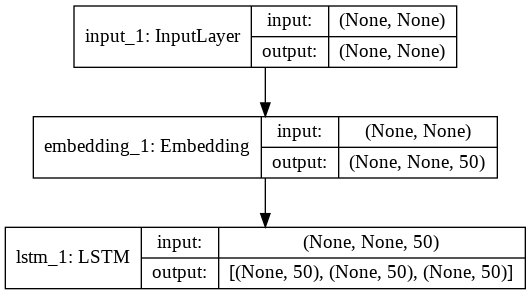

In [2]:
Image(retina=True, filename='encoder_model.png')

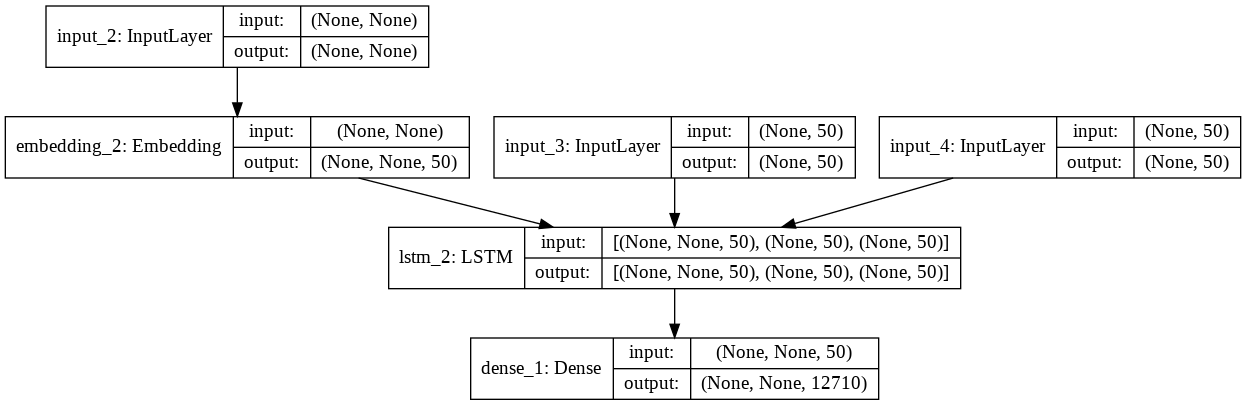

In [3]:
Image(retina=True, filename='decoder_model.png')

### Decode sample sequeces

In [260]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Evaluation on Train Dataset

In [261]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [262]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it is a difficult problem
Actual Marathi Translation:  यह समस्या बहुत कठिन है। 
Predicted Marathi Translation:  यह पास नहीं है। 


In [263]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i need to go get some eggs
Actual Marathi Translation:  मुझे कुछ अंडे खरीदने जाना है। 
Predicted Marathi Translation:  मैं अपने एक एक बार है। 


In [264]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she asked me for help
Actual Marathi Translation:  उसने मुझसे मदद मांगी। 
Predicted Marathi Translation:  वह अपने एक लिए नहीं है। 


In [265]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i got up early so that i could catch the first train
Actual Marathi Translation:  मैं जल्दी उठा था क्योंकि मुझे पहली ट्रेन पकड़नी थी। 
Predicted Marathi Translation:  मैं एक एक एक एक बार नहीं है। 


In [266]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: will he come tomorrow
Actual Marathi Translation:  वे कल आएँगे क्या 
Predicted Marathi Translation:  वह पास नहीं नहीं है। 


In [53]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i was asleep
Actual Marathi Translation:  मी झोपलेले 
Predicted Marathi Translation:  मी रडत होतो 


In [54]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i will give you this book
Actual Marathi Translation:  मी तुम्हाला हे पुस्तक देईन 
Predicted Marathi Translation:  मी तुला हे पुस्तक तुला दिलं 


In [55]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its night
Actual Marathi Translation:  रात्र आहे 
Predicted Marathi Translation:  रात्र आहे 


In [56]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this sentence has five words
Actual Marathi Translation:  या वाक्यात पाच शब्द आहेत 
Predicted Marathi Translation:  या पाच शब्द आहेत 


In [57]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: four more are needed to make fifty
Actual Marathi Translation:  पन्नास व्हायला आजून चार लागतील 
Predicted Marathi Translation:  चार गाड्या आमच्याबरोबर करायची तर या 


In [58]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: did you clean your room
Actual Marathi Translation:  तुझी खोली साफ केलीस का 
Predicted Marathi Translation:  तुझी खोली साफ केली का 


In [59]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she wrapped herself in a blanket
Actual Marathi Translation:  त्यांनी स्वतःला एका चादरीत गुंडाळून घेतलं 
Predicted Marathi Translation:  तिने एका छोट्या चादर घातली 


In [60]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he is still alive
Actual Marathi Translation:  तो अजूनही जिवंत आहे 
Predicted Marathi Translation:  ते अजूनही जिवंत आहेत 


In [61]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: thats toms
Actual Marathi Translation:  ते टॉमचं आहे 
Predicted Marathi Translation:  ती टॉमची आहे 


In [62]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom was eating a sandwich
Actual Marathi Translation:  टॉम सँडविच खात होता 
Predicted Marathi Translation:  टॉम सँडविच खात होता 


In [63]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: whats your favorite swear word
Actual Marathi Translation:  तुझी सर्वात आवडती शिवी कोणती आहे 
Predicted Marathi Translation:  तुझी सर्वात आवडती कोणती एक मोठी आहे 


In [64]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i was in australia for three months last year
Actual Marathi Translation:  गेल्या वर्षी मी तीन महिने ऑस्ट्रेलियात होते 
Predicted Marathi Translation:  गेल्या वर्षी मी तीन महिने ऑस्ट्रेलियात होते 


In [65]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: take the next right
Actual Marathi Translation:  पुढचा राइट पकडा 
Predicted Marathi Translation:  बाजूला घे 


In [66]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: why do i need to learn french
Actual Marathi Translation:  मला फ्रेंच शिकायची काय गरज आहे 
Predicted Marathi Translation:  मला फ्रेंच शिकायची का आहे 


In [67]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we won the battle
Actual Marathi Translation:  आम्ही लढाई जिंकलो 
Predicted Marathi Translation:  आम्ही लढाई जिंकलो 


In [68]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: is that your sister
Actual Marathi Translation:  त्या तुमची बहीण आहेत का 
Predicted Marathi Translation:  ते तुझी बहीण आहे का 


In [69]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom and mary are playing a video game
Actual Marathi Translation:  टॉम व मॅरी एक व्हिडिओ गेम खेळतायत 
Predicted Marathi Translation:  टॉम आणि मेरी शर्ट कोणी वाचता येत नाही आहे 


In [70]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: you cant speak french can you
Actual Marathi Translation:  तुला फ्रेंच बोलता येत नाही ना 
Predicted Marathi Translation:  तुला फ्रेंच बोलता येत नाही का नाही माहीत 


In [71]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: toms strong
Actual Marathi Translation:  टॉम बलवान आहे 
Predicted Marathi Translation:  टॉम पूर्णपणे पीत आहे 


In [73]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom backed everything up on an external hard drive
Actual Marathi Translation:  टॉमने सर्वकाही एका एक्स्टर्नल हार्ड ड्राइव्हवर बॅकअप करून ठेवलं 
Predicted Marathi Translation:  टॉमने एक सर्व मुलांना एका छोट्या परत गावात 


In [74]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: take care
Actual Marathi Translation:  काळजी घ्या 
Predicted Marathi Translation:  काळजी घे 


In [75]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im a city girl
Actual Marathi Translation:  मी शहरी मुलगी आहे 
Predicted Marathi Translation:  मी एका मुलीला ओळखतो 


In [76]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tell me that story again
Actual Marathi Translation:  ती गोष्ट मला परत सांगा 
Predicted Marathi Translation:  मला ती गोष्ट परत सांगा 


In [77]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the clock has stopped
Actual Marathi Translation:  घड्याळ थांबलंय 
Predicted Marathi Translation:  घड्याळ बंद करा 


In [78]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i like your idea
Actual Marathi Translation:  मला तुमची आयडिया आवडली 
Predicted Marathi Translation:  मला तुझी ती आवडते 


In [79]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom has eaten three hot dogs so far
Actual Marathi Translation:  टॉमने आतापर्यंत तीन हॉटडॉग खाल्ले आहेत 
Predicted Marathi Translation:  टॉमने तीन वर्षांनी काही पुस्तकं आहेत 


In [80]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he may come today
Actual Marathi Translation:  ते आज येऊ शकतात 
Predicted Marathi Translation:  तो आज येऊ शकत नाही 


In [81]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: well done
Actual Marathi Translation:  शाब्बास 
Predicted Marathi Translation:  आम्ही केलं 


In [82]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: either you or i must go in his place
Actual Marathi Translation:  त्याच्या जागी तुला किंवा मलातरी जायलाच लागेल 
Predicted Marathi Translation:  मला वाटतं ते आठ इंग्रजी हवी आहे 


In [83]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do you like moscow
Actual Marathi Translation:  तुम्हाला मॉस्को आवडतं का 
Predicted Marathi Translation:  तुला आवडलं का 


In [84]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do you write in arabic
Actual Marathi Translation:  तुम्ही अरबीत लिहिता का 
Predicted Marathi Translation:  तू अरबी तू अमेरिकेत नाहीस 


In [85]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its very hot inside
Actual Marathi Translation:  आत खूप गरम आहे 
Predicted Marathi Translation:  खूप गरम होतं 


In [86]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i am memorizing the national anthem
Actual Marathi Translation:  मी राष्ट्रगीत पाठ करतेय 
Predicted Marathi Translation:  मी विसरणार नाही 


In [87]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont understand why tom brought you here
Actual Marathi Translation:  टॉमने तुला इथे का आणलं मला कळत नाही 
Predicted Marathi Translation:  टॉम इथे काल का आणलं मला माहीत आहे 


In [88]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what did you do exactly
Actual Marathi Translation:  तुम्ही नक्की काय केलंत 
Predicted Marathi Translation:  तू नक्की काय केलंस 


In [89]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive studied english for five years
Actual Marathi Translation:  मी पाच वर्ष इंग्रजीचा अभ्यास केला आहे 
Predicted Marathi Translation:  मी इंग्रजीचा अभ्यास केला जातो 


In [90]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we will win the battle
Actual Marathi Translation:  आम्ही ही लढाई जिंकू 
Predicted Marathi Translation:  आपण ते जिंकू शकतो का 


In [91]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont like chess
Actual Marathi Translation:  मला बुद्धिबळ आवडत नाही 
Predicted Marathi Translation:  मला बुद्धिबळ आवडत नाही 


In [92]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what did you eat last night
Actual Marathi Translation:  तुम्ही काल रात्री काय खाल्लंत 
Predicted Marathi Translation:  तू काल रात्री काय केलंस 


In [93]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do it just like this
Actual Marathi Translation:  अगदी असंच करा 
Predicted Marathi Translation:  हे फक्त हवं आहे 


In [94]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont you want my phone number
Actual Marathi Translation:  माझा फोन नंबर नकोय का 
Predicted Marathi Translation:  तुला माझा फोन कोणी नंबर आहे का 


In [95]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its no problem for me to help you tomorrow morning
Actual Marathi Translation:  उद्या सकाळी तुमची मदत करण्यात मला काहीच हरकत नाही 
Predicted Marathi Translation:  इथे मी तुझी मदत करून विचार ताबडतोब नाही 


In [96]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what time do you want to meet
Actual Marathi Translation:  तुम्हाला किती वाजता भेटायचं आहे 
Predicted Marathi Translation:  तुला किती वाजता भेटायचं आहे 


In [97]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: let her sleep
Actual Marathi Translation:  तिला झोपू दे 
Predicted Marathi Translation:  तिला द्या 


In [98]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: your dog is here
Actual Marathi Translation:  तुझा कुत्रा इकडे आहे 
Predicted Marathi Translation:  तुझा कुत्रा इथे आहे 


In [99]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who called the cops
Actual Marathi Translation:  पोलिसांना कोणी बोलवलं 
Predicted Marathi Translation:  पोलिसांना कोणी बोलवलं 


In [100]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: are you a prisoner
Actual Marathi Translation:  तुम्ही कैदी आहात का 
Predicted Marathi Translation:  तुम्ही कैदी आहात का 


### Evaluation on Validation Dataset

In [101]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [102]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i want some tea without sugar
Actual Marathi Translation:  मला थोडा बिनसाखरेचा चहा हवाय 
Predicted Marathi Translation:  मला जरासा चहा देऊ शकता 


In [103]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: my wife isnt beautiful yours is
Actual Marathi Translation:  माझी बायको सुंदर नाहीये तुझी आहे 
Predicted Marathi Translation:  माझी तुझी गर्लफ्रेंड सुंदर आहे भेटलो 


In [104]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i wasnt stealing anything
Actual Marathi Translation:  मी काहीही चोरत नव्हते 
Predicted Marathi Translation:  मी काहीही काहीही दिसला 


In [105]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who lives in this house
Actual Marathi Translation:  या घरात कोण राहतं 
Predicted Marathi Translation:  या घरात कोणी असतो 


In [106]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: am i dreaming
Actual Marathi Translation:  मी स्वप्न बघतेय का 
Predicted Marathi Translation:  मी स्वप्न बघतोय का 


In [107]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: somethings happened to tom
Actual Marathi Translation:  टॉमला काहीतरी झालंय 
Predicted Marathi Translation:  टॉमला काहीतरी झालं आहे 


In [108]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: come on give it to me
Actual Marathi Translation:  चला द्या मला 
Predicted Marathi Translation:  मला आत आला तर 


In [109]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she shot him
Actual Marathi Translation:  त्यांनी त्याला गोळी मारली 
Predicted Marathi Translation:  तिने त्याला गोळी मारली 


In [110]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: all knowledge is not good
Actual Marathi Translation:  सर्वच ज्ञान काय चांगलं नसतं 
Predicted Marathi Translation:  चांगल्या घाईत लोकं नाहीयेत 


In [111]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom isnt dead
Actual Marathi Translation:  टॉम मेला नाहीये 
Predicted Marathi Translation:  टॉम मेला नाहीये 


In [112]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: just work hard
Actual Marathi Translation:  फक्त मेहनतीने काम कर 
Predicted Marathi Translation:  खूप वर्ष करू शकतं 


In [113]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tell tom to wait
Actual Marathi Translation:  टॉमला थांबायला सांग 
Predicted Marathi Translation:  टॉमला थांबायला सांगा 


In [114]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the dog jumped over a chair
Actual Marathi Translation:  कुत्र्याने खुर्चीवरून उडी मारली 
Predicted Marathi Translation:  एक कुत्र्याला दरवाजा बंद केला 


In [115]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i like short hair
Actual Marathi Translation:  मला छोटे केस आवडतात 
Predicted Marathi Translation:  मला नियम आवडतो 


In [116]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i can prove who the murderer is
Actual Marathi Translation:  खुनी कोण आहे हे मी सिद्ध करू शकतो 
Predicted Marathi Translation:  मी जिंकू शकतो हे मला माहीत आहे 


In [117]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom is a guest
Actual Marathi Translation:  टॉम पाहुणा आहे 
Predicted Marathi Translation:  टॉम एक भिंत बघितला आहे 


In [118]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: how will you stop him
Actual Marathi Translation:  तुम्ही त्याला कसं थांबवाल 
Predicted Marathi Translation:  तू त्यांना जबाबदार 


In [119]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everyone could hear what tom said
Actual Marathi Translation:  टॉम जे म्हणाला ते सर्वांना ऐकू येत होतं 
Predicted Marathi Translation:  टॉमने काय म्हटलं म्हटलं तर खरं 


In [120]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: those are my books
Actual Marathi Translation:  ती माझी पुस्तकं आहेत 
Predicted Marathi Translation:  ती माझी पुस्तकं आहेत 


In [121]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i cant see anything
Actual Marathi Translation:  मला काहीही दिसत नाहीये 
Predicted Marathi Translation:  मला काहीही दिसत नाहीये 


In [122]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the main crop of japan is rice
Actual Marathi Translation:  जपानमध्ये प्रमुख धान्य म्हणजे तांदूळ 
Predicted Marathi Translation:  जपानमध्ये किती तास 


In [123]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it wasnt mine
Actual Marathi Translation:  माझा नव्हता 
Predicted Marathi Translation:  माझं नव्हतं 


In [124]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they said anderson and his men must leave the fort
Actual Marathi Translation:  त्यांनी म्हटलं की अॅंडरसन व त्याच्या माणसांनी गड सोडला पाहिजे 
Predicted Marathi Translation:  त्याने प्रत्येक टॉमच्या प्रश्न व शकतो 


In [125]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom looks like hes going to cry
Actual Marathi Translation:  टॉमला बघून वाटतंय तो रडणार आहे 
Predicted Marathi Translation:  टॉम बागेत तो विसरले 


In [126]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i reached nagoya early this morning
Actual Marathi Translation:  मी आज सकाळी पहाटेच नागोयाला पोहोचलो 
Predicted Marathi Translation:  मी आज सकाळी लवकरच सुरू केला 


In [127]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: let me talk to tom first
Actual Marathi Translation:  आधी मला टॉमशी बोलू द्या 
Predicted Marathi Translation:  मला टॉमशी बोलू शकत नव्हते 


In [128]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she took my hand
Actual Marathi Translation:  त्यांनी माझा हात घेतला 
Predicted Marathi Translation:  तिने माझा हात 


In [129]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everybody wants recognition
Actual Marathi Translation:  सर्वांनाच मान्यता हवी असते 
Predicted Marathi Translation:  सगळे चांगले जात आहोत 


In [130]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom doesnt like wearing red
Actual Marathi Translation:  टॉमला लाल कपडे घालायला आवडत नाहीत 
Predicted Marathi Translation:  टॉमने मोठ्या शहरात नाहीत 


In [131]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im resigning on monday
Actual Marathi Translation:  मी सोमनारी राजीनामा देत आहे 
Predicted Marathi Translation:  मी सोमवारी खूष आहे 


In [132]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom has been to boston twice
Actual Marathi Translation:  टॉम बॉस्टनला दोनदा गेला आहे 
Predicted Marathi Translation:  टॉम बॉस्टनला दोन वेळा झाला आहे 


In [133]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the keys were in my bag
Actual Marathi Translation:  चाव्या माझ्या बॅगेत होत्या 
Predicted Marathi Translation:  माझ्या चाव्या खोलीत आहेत 


In [134]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everyone knew the song
Actual Marathi Translation:  गाणं सर्वांनाच माहीत होतं 
Predicted Marathi Translation:  ते गाणं सर्वांनाच माहीत आहे 


In [135]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: are those your bags
Actual Marathi Translation:  त्या तुझ्या बॅगा आहेत 
Predicted Marathi Translation:  त्या तुझ्या बॅगा आहेत 


In [136]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: money doesnt grow on trees you know
Actual Marathi Translation:  पैसे काय झाडावर नाही उगत 
Predicted Marathi Translation:  माहीत आहे विसरणार नाही का 


In [137]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i watched the news
Actual Marathi Translation:  मी बातम्या बघितल्या 
Predicted Marathi Translation:  मी बातमी स्वतः पाहिलं 


In [138]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who built it
Actual Marathi Translation:  ते कोणी बांधलं 
Predicted Marathi Translation:  कोणी करेन 


In [139]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: when did you buy your car
Actual Marathi Translation:  तुम्ही आपली गाडी कधी विकत घेतलीत 
Predicted Marathi Translation:  तू तुझी गाडी कधी विकत घेतली 


In [140]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: pakistan is a muslim country
Actual Marathi Translation:  पाकिस्तान हा मुस्लिम देश आहे 
Predicted Marathi Translation:  देश ठाऊक आहे 


In [141]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom is in his bedroom
Actual Marathi Translation:  टॉम त्याच्या बेडरूममध्ये आहे 
Predicted Marathi Translation:  टॉम त्याच्या बहिणी आहे 


In [142]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: can you do that tomorrow
Actual Marathi Translation:  ते तू उद्या करू शकतेस का 
Predicted Marathi Translation:  ते तू त्यांना करू शकतोस का 


In [143]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she can speak french
Actual Marathi Translation:  त्यांना फ्रेंच बोलता येते 
Predicted Marathi Translation:  तिला फ्रेंच बोलता येते 


In [144]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont stand up
Actual Marathi Translation:  उभा राहू नकोस 
Predicted Marathi Translation:  सोडू नकोस 


In [145]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: fold the paper in the middle
Actual Marathi Translation:  कागदाला मधून घडी घाल 
Predicted Marathi Translation:  ब्रेड हा दूर व शकतोस 


In [146]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: my son is going to be a teacher
Actual Marathi Translation:  माझा मुलगा शिक्षक बनणार आहे 
Predicted Marathi Translation:  माझा लहान भाऊ शिक्षक आहे 


In [147]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: can you ride a bicycle
Actual Marathi Translation:  तुम्हाला सायकल चालवता येते का 
Predicted Marathi Translation:  तुला सायकल चालवता येते का 


In [148]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im extremely fat
Actual Marathi Translation:  मी अतिशय जाडा आहे 
Predicted Marathi Translation:  मी खूप जाडी आहे 


In [149]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive just turned
Actual Marathi Translation:  मी आत्ताच वर्षांचा झालो आहे 
Predicted Marathi Translation:  मी फक्त माझ्या मित्राला वाट घेतली 


In [150]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive found a job
Actual Marathi Translation:  मला नोकरी सापडली आहे 
Predicted Marathi Translation:  मला एक नोकरी सापडलं 
